## Fill CRUJRA Precip over Greenland with data from GSWP3
 - uses regionmask, which is included with NPL 2025b!
 - otherwise `conda install --name cupid-infrastructure regionmask`
 - This may not be ideal as it updates lots of packages... 
Will Wieder

Jan 2026

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
from datetime import datetime
import dask

import numpy as np
import pandas as pd
import xarray as xr
import regionmask

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# CRUJRA data
Cfin = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/atm_forcing.datm7.CRUJRA.0.5d.c20241231/three_stream/'
Cftypes = ['Prec','Solr','TPQWL']
# for testing... 
#Cftypes = ['Prec']#,'Solr','TPQWL']
Cdir_in = 'clmforc.CRUJRAv2.5_0.5x0.5.'

# GSWP3 DATA
Gfin = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/atm_forcing.datm7.GSWP3.0.5d.v1.c200929/'
Gftypes = ['Precip','Solar','TPHWL']
Gdir_in = 'clmforc.GSWP3.c2011.0.5x0.5.'

vars = ['PRECTmms','FSDS',['TBOT','PSRF','QBOT','WIND','FLDS']]
debug = False

out_dir = '/glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)

In [3]:
year = 1901
v = 0
Cftype = Cftypes[v]
Gftype = Gftypes[v]
year = str(year)
# list of files
Cfiles = []
Cfiles.extend(sorted(glob(join(Cfin, '*' + Cftype + "." + year + "*.nc"))))
Cds = xr.open_mfdataset(Cfiles, decode_times=True, combine='by_coords', parallel=True)

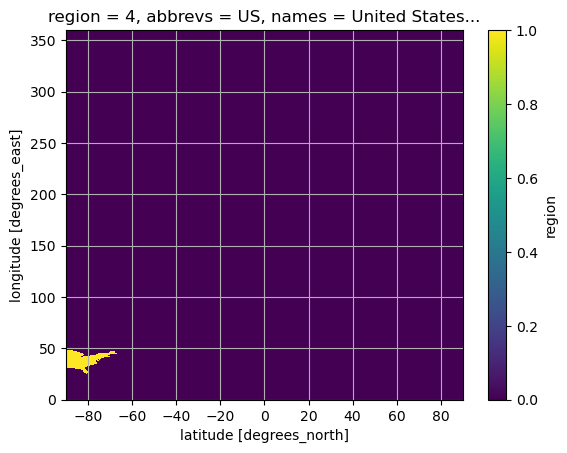

In [4]:
# This seems easier, but not working as expected
lat, lon = Cds.lat, Cds.lon
mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(lat,lon)
mask.region.names
greenland_boolean_mask = mask.isel(region=2)
#greenland_boolean_mask.sel(lat=slice(50,90),lon=slice(250,360)).plot()
greenland_boolean_mask.plot()
plt.grid()

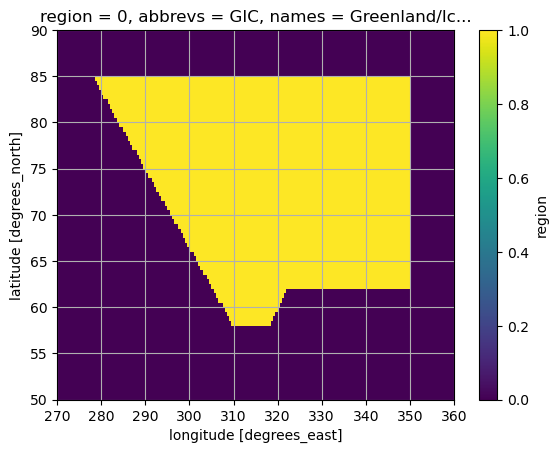

In [5]:
lat, lon = Cds.lat, Cds.lon
mask = regionmask.defined_regions.ar6.all.mask_3D(lon, lat)
mask.names
greenland_boolean_mask = (mask.isel(region=0))
greenland_boolean_mask.sel(lat=slice(50,90),lon=slice(270,360)).plot()
plt.grid()

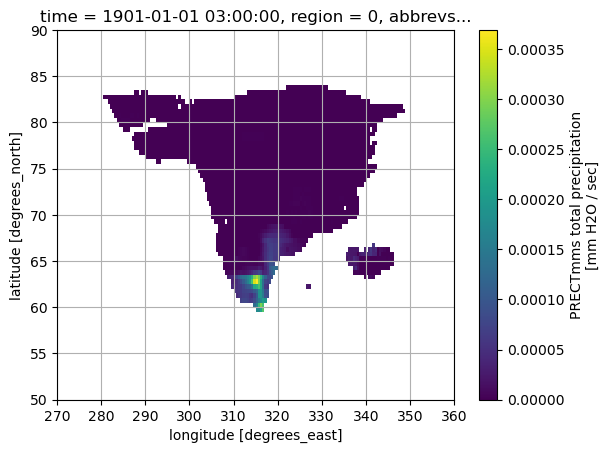

In [6]:
Cds_mask = Cds.where(greenland_boolean_mask==1)
Cds_mask.PRECTmms.isel(time=0).sel(lat=slice(50,90),lon=slice(270,360)).plot()
plt.grid()

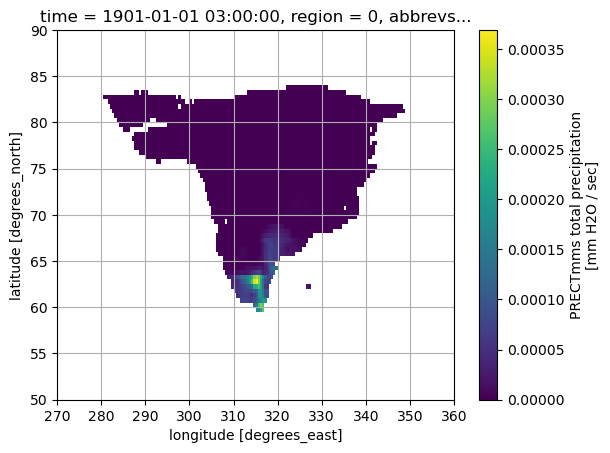

In [7]:
# Try masking out Iceland
greenland_boolean_mask2 = greenland_boolean_mask.where((greenland_boolean_mask.lon < 330) | 
                                                      (greenland_boolean_mask.lon > 350) &
                                                      (greenland_boolean_mask.lat < 62) |
                                                      (greenland_boolean_mask.lat > 67), 0)
# Check the mask
Cds_mask2 = Cds.where(greenland_boolean_mask2==1)
Cds_mask2.PRECTmms.isel(time=0).sel(lat=slice(50,90),lon=slice(270,360)).plot()
plt.grid()

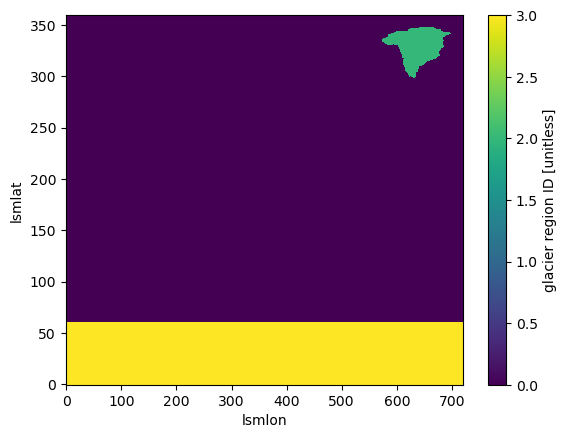

In [8]:
# Better to use gladier_region from surface dataset!
sur_dir = '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.4.0/'
sur_file = sur_dir + 'surfdata_360x720cru_hist_1850_78pfts_c251022.nc'
sur_ds = xr.open_dataset(sur_file, decode_times=True)
sur_ds.GLACIER_REGION.plot();

lat max diffs = 0.0
lon max diffs = 0.0


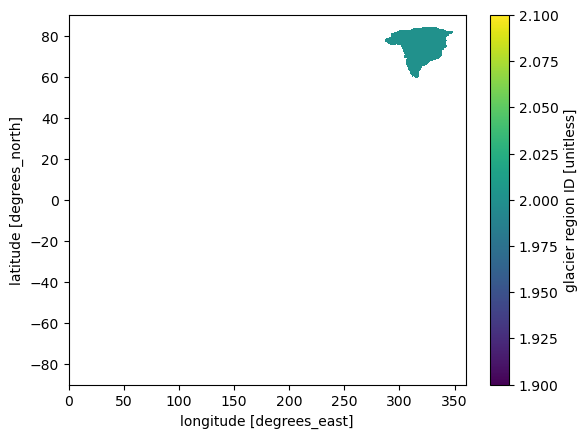

In [9]:
print('lat max diffs = '+ str((Cds.lat.values - sur_ds.LATIXY.isel(lsmlon=0).values).max()))
print('lon max diffs = '+ str((Cds.lon.values - sur_ds.LONGXY.isel(lsmlat=0).values).max()))

# Since lat & lon are identical we can safely make a mask here
greenland_mask = sur_ds.GLACIER_REGION.where(sur_ds.GLACIER_REGION==2)
greenland_mask = greenland_mask.rename({'lsmlat':'lat'}).assign_coords({"lat": Cds.lat})
greenland_mask = greenland_mask.rename({'lsmlon':'lon'}).assign_coords({"lon": Cds.lon})
greenland_mask.plot() ;

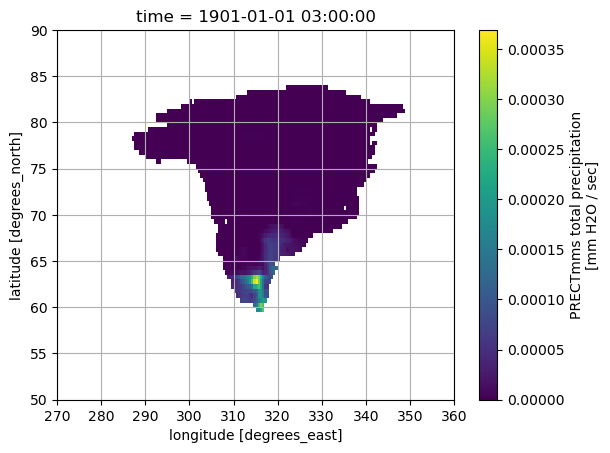

In [10]:
# Check the mask
Cds_mask3 = Cds.where(greenland_mask==2)
Cds_mask3.PRECTmms.isel(time=0).sel(lat=slice(50,90),lon=slice(270,360)).plot()
plt.grid()

In [12]:
v = 0
for Cftype in Cftypes:
    print('starting '+Cftype)
    Gftype = Gftypes[v]
    for year in range(1902, 2024):
        # cycle over GSWP3 years 2005-2014 to fill out end of TRENDY time series 2023
        if year < 2015:
            gyear = year
            ajdTime = False
        else:      
            gyear = year - 10
            ajdTime = True
        year = str(year)
        gyear = str(gyear)
        print('crujra and GSWP3 years = '+year+', '+gyear)
        # list of files
        Cfiles = []
        Gfiles = []

        Cfiles.extend(sorted(glob(join(Cfin, '*' + Cftype + "." + year + "*.nc"))))
        #Gfiles.extend(sorted(glob(join(Gfin, Gftype, '*' + Cftype + "." + gyear + "*.nc"))))
        Gfiles.extend(sorted(glob(join(Gfin, Gftype, '*' + "." + gyear + "*.nc"))))

        Cds = xr.open_mfdataset(Cfiles, decode_times=True, combine='by_coords', parallel=True)
        Gds = xr.open_mfdataset(Gfiles, decode_times=True, combine='by_coords',parallel=True)

        # check that lat-lon dimensions are identical
        if debug == True:
            print(Cfiles)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).min().values)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).max().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).min().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).max().values)

        # assign missing coords to GSWP3 (this may not be necessary?)
        Gds = Gds.assign_coords({'lon': Cds.lon})
        Gds = Gds.assign_coords({'lat': Cds.lat})

        # Couldn't get interp_like to work as intended, using resample and coarsen instead?
        # just select the nearest values for solar, time mean for others
        if Cftype == 'Solr':
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].resample(time="6h").nearest()
        else:
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].coarsen(time=2, boundary="trim").mean()
        
        if ajdTime == True :
            x = x.assign_coords({'time': Cds.time})

        #with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        #    x = Gds.PRECTmms.interp_like(Cds.PRECTmms,method='linear',assume_sorted=False)

        # Create the output dataset where GSWP3 is used south of 60S
        ds_out = Cds.copy('deep')
        ds_out[vars[v]] = xr.where(greenland_mask==2, x, ds_out[vars[v]]).reset_coords(drop=True)

        # transpose coords to get time first and add attributes
        ds_out = ds_out.transpose("time", "lat", "lon")
        ds_out['lat'].attrs = Cds['lat'].attrs
        ds_out['lon'].attrs = Cds['lon'].attrs
        ds_out['time'].attrs = Cds['time'].attrs
        #ds_out['lat'].attrs['_FillValue'] = 1.e36
        #ds_out['lon'].attrs['_FillValue'] = 1.e36
        #ds_out['time'].attrs['_FillValue'] = 1.e36
        #ds_out['LATIXY'].attrs['_FillValue'] = 1.e36
        #ds_out['LONGXY'].attrs['_FillValue'] = 1.e36
        ds_out.attrs['creation_date'] = datetime.today().strftime('%Y-%m-%d')
        ds_out.attrs['case_title3'] = 'merged with GSWP3 data over Greenland' 
        if v < 2 :
            ds_out[vars[v]].attrs = Cds[vars[v]].attrs
            ds_out[vars[v]].attrs['_FillValue'] = 1.e36
        else:
            for var in vars[v]:
                ds_out[var].attrs = Cds[var].attrs
                ds_out[var].attrs['_FillValue'] = 1.e36

        # Write out the new file
        fout = out_dir + Cdir_in + Cftype+"."+year+".nc"
        ds_out.to_netcdf(fout, format="NETCDF4")
        print('wrote '+fout)

    v = v+1

starting Prec
crujra and GSWP3 years = 1902, 1902
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1902.nc
crujra and GSWP3 years = 1903, 1903
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1903.nc
crujra and GSWP3 years = 1904, 1904
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1904.nc
crujra and GSWP3 years = 1905, 1905
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1905.nc
crujra and GSWP3 years = 1906, 1906
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1906.nc
crujra and GSWP3 years = 1907, 1907
wrote /glade/derecho/scratch/wwieder/TRENDY2024_greenland2/inputs/three_stream/clmforc.CRUJRAv2.5_0.5x0.5.Prec.1907.nc
crujra and GSWP3 years = 1908, 1908
wrote /glade/derecho

In [25]:
Cds

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 360, lon: 720, time: 1460)
Coordinates:
  * time      (time) object 12kB 1901-01-01 03:00:00 ... 1901-12-31 21:00:00
  * lon       (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat       (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    LONGXY    (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    LATIXY    (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 2GB dask.array<chunksize=(1460, 360, 720), meta=np.ndarray>
Attributes:
    creation_date:  2024-09-26
    conventions:     
    case_title:     CRUJRAv2.5 6-Hourly Atmospheric Forcing: Precipitation.
    case_title2:    merged with GSWP3 data over Antarctica

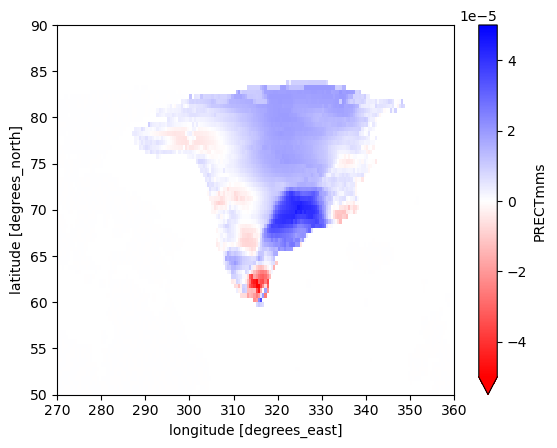

In [26]:
# Check to see differences are as expected
diff = (ds_out[vars[v]].mean('time') - Cds[vars[v]].mean('time'))
diff.sel(lat=slice(50,90),lon=slice(270,360)).plot(vmax=5e-5,vmin=-5e-5,cmap='bwr_r') ;

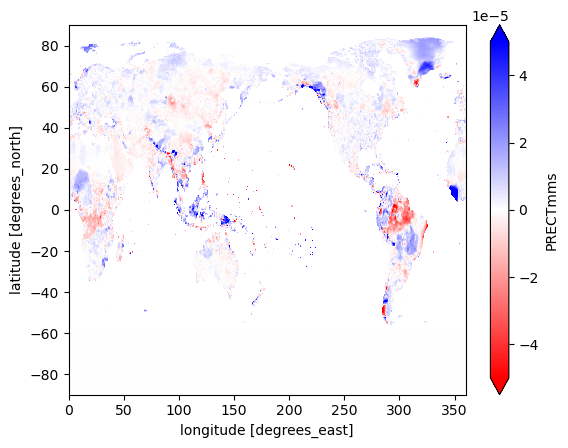

In [27]:
(Gds[vars[v]].mean('time') - Cds[vars[v]].mean('time')).plot(vmax=5e-5,vmin=-5e-5,cmap='bwr_r') ;